In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.special import logsumexp
import pymc3 as pm
import theano.tensor as TT

In [2]:
def generate_examples(p_1, n_obj, cfer_p_00, cfer_p_11):
    #for now, assume everyone classifies everything
    np.random.seed(0)
    true_classes = np.random.choice(2, p=[1-p_1, p_1], size=n_obj)
    
    n_cfer = len(cfer_p_00)
    
    p_obs_1 = np.where(true_classes[:, None]==1, cfer_p_11[None, :], (1-cfer_p_00[None, :]))
    obs_classes = np.where(np.random.uniform(0, 1, [n_obj, n_cfer]) < p_obs_1, 1, 0)
    
    return true_classes, obs_classes.T

In [3]:
p_1_true = 0.2
p_1_train = 0.5

cfer_probs = np.asarray([[0.9, 0.7],
                         [0.7, 0.9],
                         [0.8, 0.8],
                         [0.3, 0.9]])

n_real = 10000
true_fs = np.zeros(n_real)
obs_fs = np.zeros(n_real)

n_obj = 200
true, obs = generate_examples(p_1_true, n_obj, cfer_probs[:, 0], cfer_probs[:, 1])

n_train = 20
true_train, obs_train = generate_examples(p_1_train, n_train, cfer_probs[:, 0], cfer_probs[:, 1])

#for real_i in range(n_real):
#    true, obs = generate_examples(p_0, n_obj, cfer_probs[:, 0], cfer_probs[:, 1])
#    true_fs[real_i] = 1-np.mean(np.random.choice(true, size=n_obj, replace=True))

In [4]:
def make_flat(observations):
    n_cfers, n_obj = observations.shape
    obs_flat = observations.ravel()
    
    cfer_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for i in range(n_cfers):
        cfer_ids[i] = i
    cfer_ids = cfer_ids.ravel()
    
    obj_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for j in range(n_obj):
        obj_ids[:, j] = j
    obj_ids = obj_ids.ravel()
    
    return obs_flat, obj_ids, cfer_ids

In [5]:
def get_beta_pars(truths, observed):
    t0 = (truths==0)
    t1 = (truths==1)
    o0 = (observed==0)
    o1 = (observed==1)
    
    a_00 = np.count_nonzero(t0 & o0, axis=1) + 1
    b_00 = np.count_nonzero(t0 & o1, axis=1) + 1
    b_11 = np.count_nonzero(t1 & o0, axis=1) + 1
    a_11 = np.count_nonzero(t1 & o1, axis=1) + 1
    
    return a_00, b_00, a_11, b_11


In [6]:
#bayes-net style, without marginalization over outcomes
p_1f0 = 1-cfer_probs[:, 0] #true 0 -> obs 1
p_1f1 = cfer_probs[:, 1] #true 1 -> obs 1
n_cfers = len(p_1f0)


### go flat; for now, everyone classifies everything

##the "real" observations
obs_classes, obj_ids, cfer_ids = make_flat(obs)

##the training set
a_00, b_00, a_11, b_11 = get_beta_pars(true_train, obs_train) 


with pm.Model() as explicit_model:
    p_1 = pm.Uniform('p1', 0, 1)
    p_00_var = pm.Beta('p00', alpha=a_00, beta=b_00, shape=n_cfers)
    p_11_var = pm.Beta('p11', alpha=a_11, beta=b_11, shape=n_cfers)
    
    #the "real" data
    true_class = pm.Bernoulli('true_class', p_1, shape=n_obj)
    N_1_true = pm.Deterministic('N1true', TT.sum(true_class))
    p_obs_1 = TT.switch(TT.eq(true_class[obj_ids], 1), p_11_var[cfer_ids], 1-p_00_var[cfer_ids])
    observed = pm.Bernoulli('observed', p_obs_1, observed=obs_classes)
    

In [7]:
with explicit_model:
    trace = pm.sample(draws=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p11, p00, p1]
>BinaryGibbsMetropolis: [true_class]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [01:53<00:00, 194.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


/home/dwatts/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/dwatts/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/dwatts/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/dwatts/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

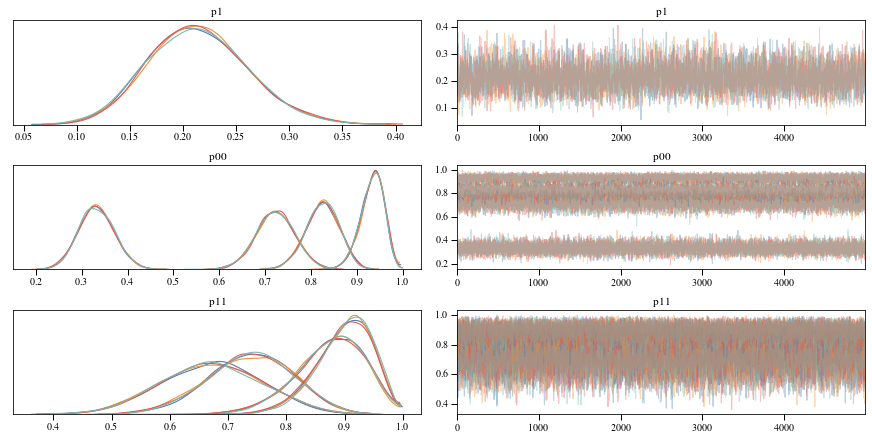

In [8]:
with explicit_model:
    pm.traceplot(trace, var_names=['p1', 'p00', 'p11'])

In [9]:
true.sum(), p_1_true

(36, 0.2)

In [10]:
cfer_probs[:, 1], cfer_probs[:, 0],

(array([0.7, 0.9, 0.8, 0.9]), array([0.9, 0.7, 0.8, 0.3]))

In [11]:
trace.varnames

['p1_interval__',
 'p00_logodds__',
 'p11_logodds__',
 'true_class',
 'p1',
 'p00',
 'p11',
 'N1true']